In [1]:
import uproot
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import LogLocator
from cycler import cycler

In [2]:
#Define global physics parameters
mu_n = -1.9130427
mu_p = 2.792847351
mu_n_simc = -1.913 #truncated precision as it appears in simc code (physics_proton.f)
mu_p_simc = 2.793 #truncated precision as it appears in simc code (physics_proton.f)
M_p = 0.938272
M_n = 0.939565
M_pi = 0.13957

In [3]:
#Define global model parameters
rior_err_fac = 0.097
arr_err_fac = 0.005
ye_t0 = -0.7
GD_range_fac = 0.71

ye_tcut = 4*pow(M_pi,2)

In [4]:
#Define parameters for Riordan, Kelly, Ye, and Arrington07
#In same order, sources:
#simc code
#Kelly Parameterization (https://journals.aps.org/prc/abstract/10.1103/PhysRevC.70.068202)
#Ye, Arrington, Hill, & Lee Parameterization, 2018 (https://doi.org/10.1016/j.physletb.2017.11.023)
#Arrington07 Global Analysis of proton elastic form factor data with tpe corrections (https://journals.aps.org/prc/pdf/10.1103/PhysRevC.76.035205)

# Define S Riordan parameters for GEn
riordan_params = {
    'a_coeffs': [0, 1.52, 2.629, 3.055],
    'b_coeffs': [1, 5.222, 0.04, 11.438],
    'a_err': [0, 0.14744, 0.255013, 0.296335],
    'b_err': [0, 0.506534, 0.00388, 1.109486]
}

# Define JJ Kelly parameters for GEn
kelly_GEn_params = {
    'a_coeffs': [0, 1.7, 0, 0],
    'a_err': [0, 0.04, 0, 0],
    'b_coeffs': [1, 3.3, 0, 0],
    'b_err': [0, 0.32, 0, 0],
}

# Define JJ Kelly parameters for GEp
kelly_GEp_params = {
    'a_coeffs': [1, -0.24, 0, 0],
    'a_err': [0, 0.12, 0, 0],
    'b_coeffs': [1, 10.98, 12.82, 21.97],
    'b_err': [0, 0.19, 1.1, 6.8],
}

# Define JJ Kelly parameters for GMn/mu_n
kelly_GMn_mun_params = {
    'a_coeffs': [1, 2.33, 0, 0],
    'a_err': [0, 1.4, 0, 0],
    'b_coeffs': [1, 14.72, 24.2, 84.1],
    'b_err': [0, 1.7, 9.8, 41],
}

# Define JJ Kelly parameters for GMp/mu_p
kelly_GMp_mup_params = {
    'a_coeffs': [1, 0.12, 0, 0],
    'a_err': [0, 0.04, 0, 0],
    'b_coeffs': [1, 10.97, 18.86, 6.55],
    'b_err': [0, 0.11, 0.28, 1.2],
}

# Define J Arrington 7 parameters for GEp
arrington07_GEp_params = {
    'a_coeffs': [1, 3.439, -1.602, 0.068],
    'b_coeffs': [1, 15.055, 48.061, 99.304, 0.012, 8.65]
}

# Define J Arrington 7 parameters for GMp
arrington07_GMp_mup_params = {
    'a_coeffs': [1, -1.465, 1.26, 0.262],
    'b_coeffs': [1, 9.627, 0, 0, 11.179, 13.245]
}

# Define the Ye parameters for GEn
ye_GEn_params = {
    'a_coeffs': [0.048919981, -0.064525054, -0.240825897, 0.392108745, 0.300445259, -0.661888687, -0.17563977, 0.624691724, -0.077684299, -0.236003975, 0.090401973, 0, 0],
    'a_err': [-2.07194073, 1.13809127, 1.01431277, -0.31330138, -0.273293676, 0.257350595, -0.206042113, -0.168497322, 0.137784515, 0.075759196, -0.02675113, -0.017525731, 0.000703582, 0.001479621, 0.000197375]
}

# Define the Ye parameters for GMn/mu_n
ye_GMn_mun_params = {
    'a_coeffs': [0.257758327, -1.079540642, 1.182183812, 0.711015086, -1.348080937, -1.662444025, 2.624354426, 1.751234495, -4.922300879, 3.197892727, -0.71207239, 0, 0],
    'a_err': [-2.06920873, 0.06431564, -0.355593786, 0.41489766, 1.95746824, 0.2705257, -1.52685784, -0.443527359, 0.516884065, 0.207915837, -0.07486657, -0.042541143, 0.00154965, 0.003253223, 0.00042082]
}

# Define the Ye parameters for GEp
ye_GEp_params = {
    'a_coeffs': [0.239163298, -1.109858574, 1.444380813, 0.479569466, -2.286894742, 1.126632985, 1.250619844, -3.631020472, 4.082217024, 0.504097346, -5.085120461, 3.967742544, -0.981529071],
    'a_err': [-1.97750308, -0.446566998, 0.294508717, 1.54467525, 0.905268347, -0.600008111, -1.10732394, -0.098598272, 0.463035988, 0.137729116, -0.078299163, -0.036305693, 0.002642193, 0.003132614, 0.000389594]
}

# Define the Ye parameters for GMp/mu_p
ye_GMp_mup_params = {
    'a_coeffs': [0.264142994, -1.095306122, 1.218553782, 0.661136494, -1.405678925, -1.356418439, 1.447029155, 4.235669736, -5.334045653, -2.916300521, 8.707403068, -5.706999944, 1.280814376],
    'a_err': [-1.76549673, 0.167218457, -1.20542733, -0.472244127, 1.41548871, 0.661320779, -0.816422909, -0.373804477, 0.262223992, 0.128886639, -0.039090151, -0.024499518, 0.00083427, 0.001882264, 0.000243073]
}

In [5]:
# Define the tau, dipole form factor, and Ye functions
def tau(Q2, M):
    return Q2 / (4 * M**2)

def GD(Q2, GD_fac):
    return (1 + Q2 / GD_fac) ** -2

def ye_z(Q2, tcut, t0):
    return ( np.sqrt(tcut+Q2) - np.sqrt(tcut-t0) ) / ( np.sqrt(tcut+Q2) + np.sqrt(tcut-t0) ) 

def ye_x(Q2):
    if Q2 <= 0:
        return 0
    return np.log10(Q2)

In [34]:
# Define parameterization functions

# Riordan parameterization for GEn/GD
def riordan_parameterization(tau_n, a_coeffs, b_coeffs):
    num = sum(a * tau_n**k for k, a in enumerate(a_coeffs))  # Sum of a_k * tau_p^k
    den = sum(b * tau_n**k for k, b in enumerate(b_coeffs))  # Sum of b_k * tau_p^k
    return num / den if den != 0 else float('inf')  # Avoid division by zero

def riordan_err(tau_value, a_coeffs, a_err, b_coeffs, b_err):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    num_err = sum(a * tau_value**k for k, a in enumerate(a_err))
    den_err = sum(b * tau_value**k for k, b in enumerate(b_err))
    
    # Ensure num and den are not zero for the error calculation
    epsilon = 1e-10
    num = num if abs(num) > epsilon else epsilon
    den = den if abs(den) > epsilon else epsilon

    # Now compute the total error
    tot_err = abs(num/den) * np.sqrt((num_err/num)**2 + (den_err/den)**2)
    
    return tot_err

# Kelly parameterization for GEn, GEp, GMn, GMp
def kelly_parameterization(tau_value, a_coeffs, b_coeffs):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    return num / den if den != 0 else float('inf')  # Avoid division by zero

def kelly_upper_errband(tau_value, a_coeffs, b_coeffs, a_err, b_err):
    upper_a_coeffs = [a + a_e for a, a_e in zip(a_coeffs, a_err)]
    upper_b_coeffs = [b + b_e for b, b_e in zip(b_coeffs, b_err)]

    # Calculate the numerator and denominator using the upper bound coefficients
    num = sum(a * tau_value**k for k, a in enumerate(upper_a_coeffs))  # Sum of (a_k + a_err_k) * tau^k
    den = sum(b * tau_value**k for k, b in enumerate(upper_b_coeffs))  # Sum of (b_k + b_err_k) * tau^k

    # Return the ratio or float('inf') if the denominator is zero
    return num / den if den != 0 else float(0)

def kelly_lower_errband(tau_value, a_coeffs, b_coeffs, a_err, b_err):
    lower_a_coeffs = [a - a_e for a, a_e in zip(a_coeffs, a_err)]
    lower_b_coeffs = [b - b_e for b, b_e in zip(b_coeffs, b_err)]

    # Calculate the numerator and denominator using the lower bound coefficients
    num = sum(a * tau_value**k for k, a in enumerate(lower_a_coeffs))  # Sum of (a_k + a_err_k) * tau^k
    den = sum(b * tau_value**k for k, b in enumerate(lower_b_coeffs))  # Sum of (b_k + b_err_k) * tau^k

    # Return the ratio or float('inf') if the denominator is zero
    return num / den if den != 0 else float(0)

# Arrington07 parameterization for GEp, GMp
def arrington07_parameterization(tau_value, a_coeffs, b_coeffs):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    return num / den if den != 0 else float('inf')  # Avoid division by zero

def arrington07_err(Q2, arrington_factor):
    err = Q2 * arrington_factor
    return err

# Ye parameterization for GEn, GEp, GMn, GMp
def ye_parameterization(z_value, a_coeffs):
    return sum(a * z_value**k for k, a in enumerate(a_coeffs))

def ye_error(x_value, a_err):
    return sum(a * x_value**k for k, a in enumerate(a_err))


In [73]:
#Test kelly parameterization output
test_Q2 = 10

test_tau = tau(test_Q2, M_n)
test_GD = GD(test_Q2, GD_range_fac)

# GMn
GMn_example = kelly_parameterization(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'])
GMn_over_GD = GMn_example / test_GD

GMn_err = kelly_err(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err']) 
GMn_error_upper = kelly_upper_errband(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err'])
GMn_error_lower = kelly_lower_errband(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err'])

GMn_over_GD_err = GMn_err / test_GD
GMn_over_GD_upper = GMn_error_upper / test_GD
GMn_over_GD_lower = GMn_error_lower / test_GD

# GEn
GEn_example = kelly_parameterization(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs']) * test_GD #necessary for GEn parameterization on kelly
GEn_over_GD = GEn_example / test_GD

GEn_err = kelly_err(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err']) * test_GD
GEn_error_upper = kelly_lower_errband(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err']) * test_GD
GEn_error_lower = kelly_upper_errband(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err']) * test_GD

GEn_over_GD_err = GEn_err / test_GD
GEn_over_GD_upper = GEn_error_upper / test_GD
GEn_over_GD_lower = GEn_error_lower / test_GD

# GEp
GEp_example = kelly_parameterization(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'])
GEp_over_GD = GEp_example / test_GD

GEp_err = kelly_err(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err'])
GEp_error_upper = kelly_upper_errband(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err'])
GEp_error_lower = kelly_lower_errband(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err'])

GEp_over_GD_err = GEp_err / test_GD
GEp_over_GD_upper = GEp_error_upper / test_GD
GEp_over_GD_lower = GEp_error_lower / test_GD

# GMp
GMp_example = kelly_parameterization(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'])
GMp_over_GD = GMp_example / test_GD

GMp_err = kelly_err(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err'])
GMp_error_upper = kelly_upper_errband(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err'])
GMp_error_lower = kelly_lower_errband(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err'])

GMp_over_GD_err = GMp_err / test_GD
GMp_over_GD_upper = GMp_error_upper / test_GD
GMp_over_GD_lower = GMp_error_lower / test_GD

print(f"test GD={test_GD}")

print(f"GMn/GD at tau={test_tau}: {GMn_over_GD}")
print(f"GMn err / GD at tau={test_tau}: {GMn_over_GD_err}")
print(f"GMn upper / GD at tau={test_tau}: {GMn_over_GD_upper}")
print(f"GMn lower / GD at tau={test_tau}: {GMn_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"GEn/GD at tau={test_tau}: {GEn_over_GD}")
print(f"GEn err / GD at tau={test_tau}: {GEn_over_GD_err}")
print(f"GEn upper / GD at tau={test_tau}: {GEn_over_GD_upper}")
print(f"GEn lower / GD at tau={test_tau}: {GEn_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"GEp/GD at tau={test_tau}: {GEp_over_GD}\n")
print(f"GEp err / GD at tau={test_tau}: {GEp_over_GD_err}")
print(f"GEp upper / GD at tau={test_tau}: {GEp_over_GD_upper}")
print(f"GEp lower / GD at tau={test_tau}: {GEp_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"GMp/GD at tau={test_tau}: {GMp_over_GD}\n")
print(f"GMp err / GD at tau={test_tau}: {GMp_over_GD_err}")
print(f"GMp upper / GD at tau={test_tau}: {GMp_over_GD_upper}")
print(f"GMp lower / GD at tau={test_tau}: {GMp_over_GD_lower}")


test GD=0.004394786236934861
GMn/GD at tau=2.831954998779218: 0.8053465889628727
GMn err / GD at tau=2.831954998779218: 0.14922509635189485
GMn upper / GD at tau=2.831954998779218: 0.8322432069203556
GMn lower / GD at tau=2.831954998779218: 0.7302460370829909

----------------------------------------

GEn/GD at tau=2.831954998779218: 0.465356538552174
GEn err / GD at tau=2.831954998779218: 0.01490440112330247
GEn upper / GD at tau=2.831954998779218: 0.4980329265967997
GEn lower / GD at tau=2.831954998779218: 0.43794375327489743

----------------------------------------

GEp/GD at tau=2.831954998779218: 0.11498514925788085

GEp err / GD at tau=2.831954998779218: 0.04309303509638127
GEp upper / GD at tau=2.831954998779218: 0.18831072326542897
GEp lower / GD at tau=2.831954998779218: -0.009440522705142571

----------------------------------------

GMp/GD at tau=2.831954998779218: 0.918037085506417

GMp err / GD at tau=2.831954998779218: 0.027620028247726105
GMp upper / GD at tau=2.8319549

In [87]:
# Initialize Q2
Q2_values = np.linspace(0, 20, 500)

In [88]:
# Initialize GEn arrays separately to accomodate first order error band calculations
GEn_over_GD_values = []
GEn_upper_values = []
GEn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEn_val = kelly_parameterization(tau_val, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs']) * GD_val
    GEn_over_GD = GEn_val / GD_val
    
    GEn_error_upper = kelly_upper_errband(tau_val, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err'])
    GEn_error_lower = kelly_lower_errband(tau_val, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err'])
    
    # Store the calculated values
    GEn_over_GD_values.append(GEn_over_GD)
    GEn_upper_values.append(GEn_error_upper)
    GEn_lower_values.append(GEn_error_lower)
    
#GMn
GMn_over_GD_values = []
GMn_upper_values = []
GMn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMn_val = kelly_parameterization(tau_val, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'])
    GMn_over_GD = GMn_val / GD_val
    
    GMn_error_upper = kelly_upper_errband(tau_val, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err']) / GD_val
    GMn_error_lower = kelly_lower_errband(tau_val, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err']) / GD_val
    
    # Store the calculated values
    GMn_over_GD_values.append(GMn_over_GD)
    GMn_upper_values.append(GMn_error_upper)
    GMn_lower_values.append(GMn_error_lower)
    
#GMp
GMp_over_GD_values = []
GMp_upper_values = []
GMp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMp_val = kelly_parameterization(tau_val, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'])
    GMp_over_GD = GMp_val / GD_val
    
    GMp_error_upper = kelly_upper_errband(tau_val, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err']) / GD_val
    GMp_error_lower = kelly_lower_errband(tau_val, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err']) / GD_val
    
    # Store the calculated values
    GMp_over_GD_values.append(GMp_over_GD)
    GMp_upper_values.append(GMp_error_upper)
    GMp_lower_values.append(GMp_error_lower)
    
#GEp
GEp_over_GD_values = []
GEp_upper_values = []
GEp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEp_val = kelly_parameterization(tau_val, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'])
    GEp_over_GD = GEp_val / GD_val
    
    GEp_error_upper = kelly_upper_errband(tau_val, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err']) / GD_val
    GEp_error_lower = kelly_lower_errband(tau_val, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err']) / GD_val
    
    # Store the calculated values
    GEp_over_GD_values.append(GEp_over_GD)
    GEp_upper_values.append(GEp_error_upper)
    GEp_lower_values.append(GEp_error_lower)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(Q2_values, GEn_over_GD_values, label='GEn/GD', color='blue')
# plt.fill_between(Q2_values, GEn_lower_values, GEn_upper_values, color='lightblue', alpha=0.5, label='Error Band')
# plt.xlabel('$Q^2$ (GeV$^2$)')
# plt.ylabel('$GE_{n}/GD$')
# plt.title('Kelly GEn/GD with Error Bands')
# plt.xscale('log')
# plt.legend()
# plt.grid(True, which="both", ls="--")
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(Q2_values, GMn_over_GD_values, label='GMn/mu_n/GD', color='green')
# plt.fill_between(Q2_values, GMn_lower_values, GMn_upper_values, color='lightgreen', alpha=0.5, label='Error Band')
# plt.xlabel('$Q^2$ (GeV$^2$)')
# plt.ylabel('$GM_{n}/(\mu_pGD$')
# plt.title('Kelly GMn/mu_n/GD with Error Bands')
# plt.xscale('log')
# plt.legend()
# plt.grid(True, which="both", ls="--")
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(Q2_values, GEp_over_GD_values, label='GEp/GD', color='red')
# plt.fill_between(Q2_values, GEp_lower_values, GEp_upper_values, color='pink', alpha=0.5, label='Error Band')
# plt.xlabel('$Q^2$ (GeV$^2$)')
# plt.ylabel('$GE_{p}/GD$')
# plt.title('Kelly GEp/GD with Error Bands')
# plt.xscale('log')
# plt.legend()
# plt.grid(True, which="both", ls="--")
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(Q2_values, GMp_over_GD_values, label='GMp/mu_p/GD', color='orange')
# plt.fill_between(Q2_values, GMp_lower_values, GMp_upper_values, color='#FFA500', alpha=0.5, label='Error Band')
# plt.xlabel('$Q^2$ (GeV$^2$)')
# plt.ylabel('$G_M^p/(\mu_{p}GD)$')
# plt.title('Kelly GMp/mu_p/GD with Error Bands')
# plt.xscale('log')
# plt.legend()
# plt.grid(True, which="both", ls="--")
# plt.show()

In [90]:
#Plotting functions

def plot_curve_with_error_bands(Q2_values, curve_values, upper_band_values, lower_band_values, title, ylabel='$G(Q^2)/GD(Q^2)$', curve_color='blue', band_color='lightblue'):
    plt.figure(figsize=(10, 6))
    plt.plot(Q2_values, curve_values, label='Central Curve', color=curve_color)
    plt.fill_between(Q2_values, lower_band_values, upper_band_values, color=band_color, alpha=0.3, label='Error Band')
    plt.xscale('log')
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()
    
    
    
def plot_all_curves_by_form_factor(Q2_values, curves_data, titles, ylabel='$G(Q^2)/GD(Q^2)$'):
    plt.figure(figsize=(20, 10))
    colors = ['blue', 'green', 'red', 'purple']
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'plum']
    
    for i, (curve_values, upper_band_values, lower_band_values) in enumerate(curves_data):
        plt.subplot(2, 2, i+1)
        plt.plot(Q2_values, curve_values, label=f'{titles[i]} Central Curve', color=colors[i])
        plt.fill_between(Q2_values, lower_band_values, upper_band_values, color=band_colors[i], alpha=0.3, label=f'{titles[i]} Error Band')
        plt.xscale('log')
        plt.xlabel('$Q^2$ (GeV$^2$)')
        plt.ylabel(ylabel)
        plt.title(titles[i])
        plt.legend()
        plt.grid(True, which='both', linestyle='--')
    
    plt.tight_layout()
    plt.show() 

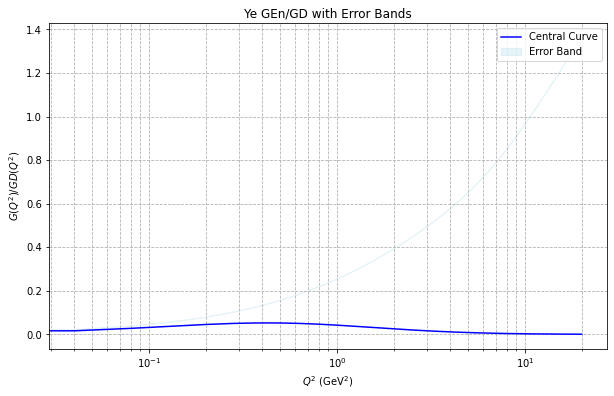

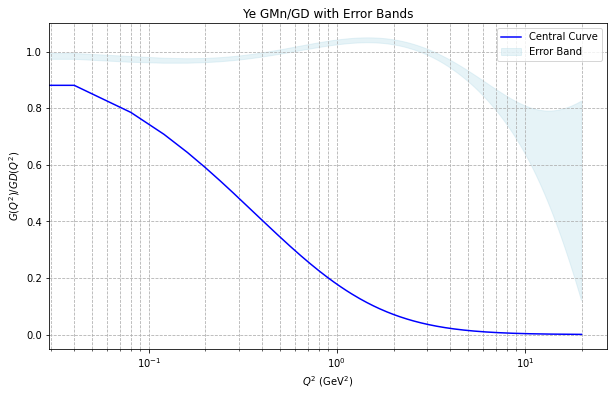

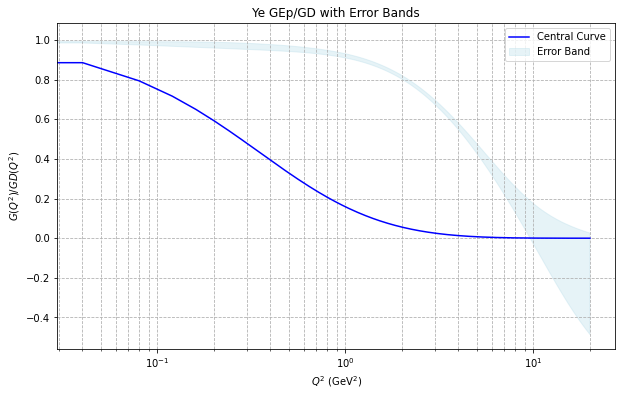

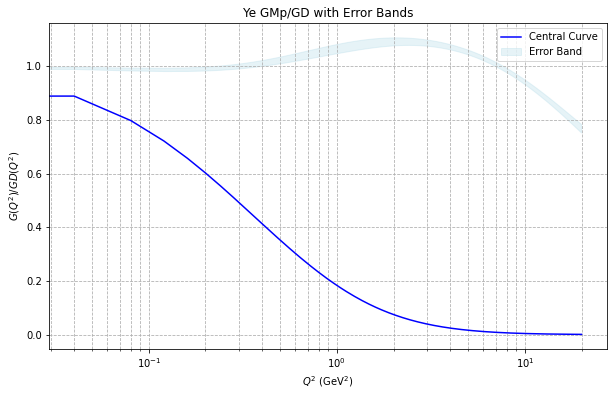

In [91]:
#plot_curve_with_error_bands(Q2_values, GEn_over_GD_values, GEn_upper_values, GEn_lower_values, 'Kelly GEn/GD with Error Bands')
#plot_curve_with_error_bands(Q2_values, GEn_values_riordan_simple, upper_bands_riordan_simple, lower_bands_riordan_simple, 'Riordan GEn/GD with Error Bands')
plot_curve_with_error_bands(Q2_values, ye_GEn_values, ye_upper_band_GEn, ye_upper_band_GEn, 'Ye GEn/GD with Error Bands')

#plot_curve_with_error_bands(Q2_values, GMn_over_GD_values, GMn_upper_values, GMn_lower_values, 'Kelly GMn/GD with Error Bands')
plot_curve_with_error_bands(Q2_values, ye_GMn_values, ye_upper_band_GMn, ye_lower_band_GMn, 'Ye GMn/GD with Error Bands')

#plot_curve_with_error_bands(Q2_values, GEp_over_GD_values, GEp_upper_values, GEp_lower_values, 'Kelly GEp/GD with Error Bands')
plot_curve_with_error_bands(Q2_values, ye_GEp_values, ye_upper_band_GEp, ye_lower_band_GEp, 'Ye GEp/GD with Error Bands')

#plot_curve_with_error_bands(Q2_values, GMp_over_GD_values, GMp_upper_values, GMp_lower_values, 'Kelly GMp/GD with Error Bands')
plot_curve_with_error_bands(Q2_values, ye_GMp_values, ye_upper_band_GMp, ye_lower_band_GMp, 'Ye GMp/GD with Error Bands')

In [16]:
def plot_single_curve_no_error(curve_data, curve_color='blue', log_scale_x=False):
    plt.figure(figsize=(10, 6))
    
    Q2_values, G_values, label = curve_data
    
    if log_scale_x:
        plt.xscale('log')
    
    # Check and remove any zero or negative values for log scale
    if log_scale_x:
        Q2_values, G_values = zip(*[(q2, g) for q2, g in zip(Q2_values, G_values) if q2 > 0])

    plt.plot(Q2_values, G_values, label=label, color=curve_color)
    
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G(Q^2)$')
    plt.title(f'{label}')
    
    if log_scale_x:
        plt.xlim(min(Q2_values), max(Q2_values))
    
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

In [17]:
def plot_curves(curve_data, log_scale_x=False, line_at_one=True, title='Comparison of Form Factor Curves'):
    plt.figure(figsize=(10, 6))
    
    # Draw a horizontal line at y=1 or y=0 based on the option
    if line_at_one:
        plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
    else:
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    
    # Define colors for the curves and their error bands
    colors = plt.cm.tab10.colors  # Use tab10 colormap for variety in colors
    
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(curve_data):
        color = colors[i % len(colors)]
        plt.plot(Q2_values, G_values, label=label, color=color)
        plt.fill_between(Q2_values, lower_band, upper_band, color=color, alpha=0.5)

    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G(Q^2)$')
    plt.title(title)

    # Remove grid lines
    plt.grid(False)
    
    if log_scale_x:
        plt.xscale('log')
        positive_Q2_values = [q2 for q2 in Q2_values if q2 > 0]
        if positive_Q2_values:
            plt.xlim(min(positive_Q2_values), max(Q2_values))

        # Explicitly setting minor ticks for logarithmic scale
        ax = plt.gca()
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))

    else:
        plt.xlim(0, 60)

    plt.ylim(min(min(lower_band), 0), max(upper_band) * 1.2)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

In [18]:
def plot_single_curve(curve_data, curve_color='blue', fill_color='lightblue', log_scale_x=False):
    plt.figure(figsize=(10, 6))
    
    Q2_values, G_values, upper_band, lower_band, label = curve_data

    if log_scale_x:
        plt.xscale('log')
    
    # Check and remove any zero or negative values for log scale
    if log_scale_x:
        Q2_values, G_values, upper_band, lower_band = zip(
            *[(q2, g, u, l) for q2, g, u, l in zip(Q2_values, G_values, upper_band, lower_band) if q2 > 0]
        )

    plt.plot(Q2_values, G_values, label=label, color=curve_color)
    plt.fill_between(Q2_values, lower_band, upper_band, color=fill_color, alpha=0.5, label=f'{label} Error')
    
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G(Q^2)$')
    plt.title(f'{label} with Error Bands')
    
    if log_scale_x:
        plt.xlim(min(Q2_values), max(Q2_values))
    else:
        plt.xlim(0, 20)

    # Adjust y-limits based on the curve and its error bands
    plt.ylim(min(min(lower_band), 0), max(upper_band) * 1.2)
    
    plt.legend()
    plt.grid(True, which="both", ls="--")  # Grid lines and specify which for log scale
    plt.show()

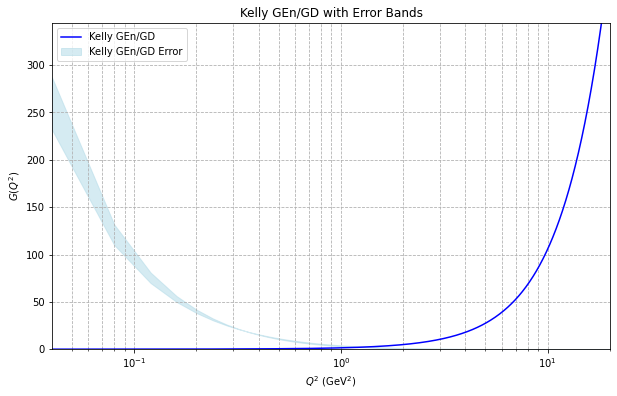

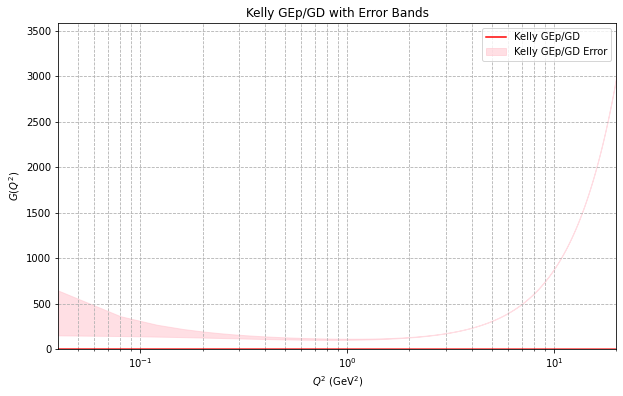

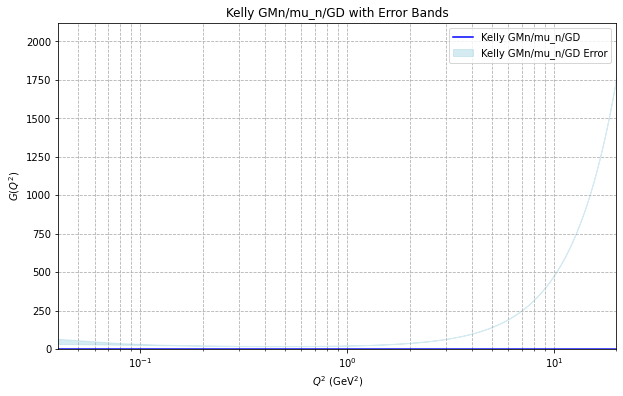

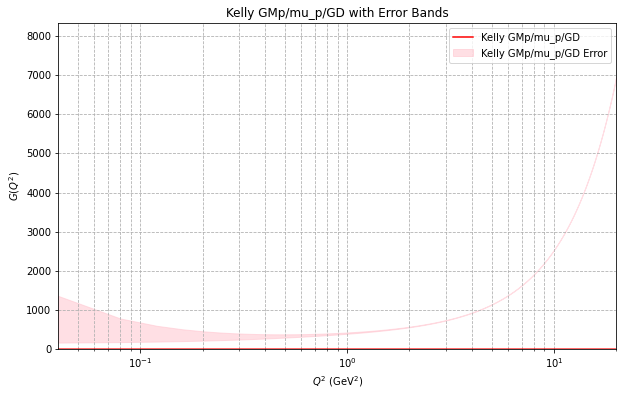

In [19]:
#plot_curves(GEn_curve_data)

#plot_single_curve([Riordan_GEn_curve_data])

# plot_single_curve_no_error(t11, log_scale_x=True)
# plot_single_curve_no_error(t21, log_scale_x=True)
# plot_single_curve_no_error(t31, log_scale_x=True)

# plot_single_curve_no_error(t1, log_scale_x=True)
# plot_single_curve_no_error(t2, log_scale_x=True)
# plot_single_curve_no_error(t3, log_scale_x=True)

#plot_curves(test, log_scale_x=True, title='test')

plot_single_curve(kelly_GEn_curve_data, log_scale_x=True)
plot_single_curve(kelly_GEp_curve_data, log_scale_x=True, curve_color='red', fill_color='pink')
plot_single_curve(kelly_GMn_curve_data, log_scale_x=True)
plot_single_curve(kelly_GMp_curve_data, log_scale_x=True, curve_color='red', fill_color='pink')
#plot_single_curve([arrington07_GEp_curve_data], curve_color='red', fill_color='pink', log_scale_x=True)
#plot_single_curve([arrington07_GMp_curve_data], curve_color='red', fill_color='pink', log_scale_x=True)
#plot_single_curve([ye_GEn_curve_data])
#plot_single_curve([ye_GEp_curve_data], curve_color='red', fill_color='pink', log_scale_x=True)
#plot_single_curve([ye_GMn_curve_data])
#plot_single_curve([ye_GMp_curve_data], curve_color='red', fill_color='pink', log_scale_x=True)

# plot_curves(GEn_curve_data, log_scale_x=True, title='GEn Fit Comparison', line_at_one=False)
# plot_curves(GEp_curve_data, log_scale_x=True, title='GEp Fit Comparison')
# plot_curves(GMn_curve_data, log_scale_x=True, title='GMn Fit Comparison')
# plot_curves(GMp_curve_data, log_scale_x=True, title='GMp Fit Comparison')